#1. Introduction
This colab includes crossvalidation, negative sampling, works with the latest feature set and includes **SMOTE** and **RandomOverSample**. V5.2 now supports training the best catboost model for use in the pipeline. The files you need to run this colab are the output of "Feature Generation for CatBoost" in the RE map and "glove.6B.300d.txt" in the "Pre-Trained NER Models Links" file.

This colab is structured as follows:

* ***Section 1*** deals with the loading of the required libraries and the loading of the initial data.

* ***Section 2*** contains the adapted crossvalidation functions for the experiments. No output will be generated if you run this section.

* ***Section 3*** investigates Negative Sampling and the Negative Sampling Rate.

* ***Section 4*** talks about the incorporation of SMOTE into the data enhancement for the use with Catboost.

* ***Section 5*** lays out a brief explanation of RandomOverSampling.

* ***Section 6*** will actually show results from the different crossvalidation functions layed out in section 2.

* ***Section 7*** will save the best model from the crossvalidation using the best under/oversampling method researched in section 6 for use in the pipeline.

##1.1. Preliminaries

In this section we install the required packages, load the needed libraries, load the data and load the init functions into memory.

In [ ]:
!pip install catboost
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 20.8 MB/s eta 0:00:00


In [ ]:
# @title Importing Libraries

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import copy


from google.colab import drive

drive.mount('/content/drive/')

#Init variables:
SEED = 42

Mounted at /content/drive/


In [ ]:
# @title These are support functions for Catboost.
def data_preparation(data, SEED):

    X= data.drop('relation_type', axis=1)
    y= data.relation_type

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.80, random_state=SEED)
    #We check for categorical features on the type of the features themselves but also via pd.api which is more rigorous
    categorical_features_indices = [i for i, typ in enumerate(X.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(X.iloc[:, i])]

    return X_train, X_validation, y_train, y_validation, categorical_features_indices

def get_feature_importance(model, train_pool, X_train):
    """
    Get the feature importances from a trained model.

    Parameters:
    - model: The trained model from which to get the feature importances.
    - train_pool: The Pool object used for training the model, containing the training data.
    - X_train: The DataFrame containing the training features, used to get the feature names.

    Returns:
    - features: A dictionary mapping feature names to their importance scores, sorted in descending order of importance.
    """

    feature_importances = model.get_feature_importance(train_pool)
    feature_names = X_train.columns
    features = {}
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        features[name] = score

    return features


def negative_sampling(df_positive, df_negative, R, SEED):
    """
    This function performs negative sampling from a 'negative' dataframe (df_negative)
    for each observation in a 'positive' dataframe (df_positive) by selecting R random
    examples from the negative dataframe without replacement.

    Parameters:
    df_positive (pd.DataFrame): DataFrame containing positive observations.
    df_negative (pd.DataFrame): DataFrame containing negative observations.
    R (int): Number of negative samples to select per positive observation.
    SEED (int): Random seed for reproducibility.

    Returns:
    pd.DataFrame: A new DataFrame containing all observations from df_positive
    followed by the randomly selected observations from df_negative.
    """
    # Setting the random seed for reproducibility
    np.random.seed(SEED)

    # Ensure we do not attempt to sample more items than exist in the negative DataFrame
    """
    if R * len(df_positive) > len(df_negative):
        raise ValueError("Not enough negative samples to fulfill the request without replacement.")"""

    # Sample without replacement a total of R * len(df_positive) items from the negative DataFrame
    total_samples_needed = R * len(df_positive)
    total_samples_needed = int(total_samples_needed)
    sampled_indices = np.random.choice(df_negative.index, size=total_samples_needed, replace=True)
    sampled_negatives = df_negative.loc[sampled_indices].copy()

    # Reset index to avoid index overlap issues when concatenating
    sampled_negatives.reset_index(drop=True, inplace=True)
    df_positive.reset_index(drop=True, inplace=True)

    # Concatenate the positive DataFrame with the sampled negative DataFrame
    result_df = pd.concat([df_positive, sampled_negatives], ignore_index=True)

    return result_df


In [ ]:
# @title Evaluation Functions
def evaluate_model_performance(model, X_val, y_val, SMOTE_check, fold_count,verbose=False):

    # Make predictions on the validation set
    predictions = model.predict(X_val)

    # Calculate the F1 score for verbose output
    if verbose:
        f1_weighted = f1_score(y_val, predictions, average='weighted', zero_division=0)
        print("\n---------------------------------------\n")
        print(f'Weighted F1 Score for all predicted labels: {round(f1_weighted, 4)}')
        print("\n---------------------------------------\n")

        f1_macro = f1_score(y_val, predictions, average='macro', zero_division=0)
        print(f'Macro F1 Score for all predicted labels: {round(f1_macro, 4)}')
        print("\n---------------------------------------\n")

    # Flatten predictions and combine them into a DataFrame
    predictions_flatten = predictions.flatten()
    results_df = pd.DataFrame({'Actual': y_val, 'Predicted': predictions_flatten})

    # Extract unique class labels
    class_labels = np.unique(results_df['Actual'])

    # Calculate label-wise precision, recall, and F1 scores
    P, R, F1, S = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average=None, labels=class_labels, zero_division=0)

    if verbose:
        # Filter out "no_relation" rows if necessary
        filtered_results_df = results_df[results_df['Actual'] != "no_relation"]

        f1_weighted_filtered = f1_score(filtered_results_df['Actual'], filtered_results_df['Predicted'], average='weighted', zero_division=0)
        print(f'Weighted F1 Score (excluding "no_relation"): {round(f1_weighted_filtered, 4)}')
        print("\n---------------------------------------\n")



    # Calculate aggregate precision, recall, and F1 scores
    P_WAggregated, R_WAggregated, F1_WAggregated, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted', labels=class_labels, zero_division=0)

    P_MAggregated, R_MAggregated, F1_MAggregated, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='macro', labels=class_labels, zero_division=0)

    P_MicAggregated, R_MicAggregated, F1_MicAggregated, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='micro', labels=class_labels, zero_division=0)

    metrics_aggregated = {
        'weighted': {
            'Precision': P_WAggregated,
            'Recall': R_WAggregated,
            'F1-Score': F1_WAggregated
        },
        'macro': {
            'Precision': P_MAggregated,
            'Recall': R_MAggregated,
            'F1-Score': F1_MAggregated
        },
        'micro': {
            'Precision': P_MicAggregated,
            'Recall': R_MicAggregated,
            'F1-Score': F1_MicAggregated
        }
    }

    # Create a mapping for individual labels
    metrics_label_mapping = {
        label: {
            'Precision': p,
            'Recall': r,
            'F1-Score': f1,
            'Support': s
        } for label, p, r, f1, s in zip(class_labels, P, R, F1, S)
    }

    if verbose:
      metric_per_label(class_labels, F1, fold_count, SMOTE_check)

    return metrics_label_mapping, metrics_aggregated

# To print out metric per label after each training of a catboost. This takes into account wether we use SMOTE or not.
# Because in the case we use SMOTE a conversion of the numerical label to a string label needs to happen first, as SMOTE needs numerical data.
def metric_per_label(labels, metric, fold_count,check= False):
  if check:

    # Get the class labels from the LabelEncoder, note that this was a global variable.
    original_labels = label_encoder.inverse_transform(labels)

    # Map F1 scores to class labels and display
    f1_scores_label_mapping = dict(zip(original_labels, metric))
    header = "{:<35} {:<15}\n".format("Label", "F1")
    print(header)
    row_format = "{:<35} {:<15}"
    for label, score in f1_scores_label_mapping.items():
        print(row_format.format(label, round(score, 4)))

    """print(f"Metrics per label for fold {fold+1}\n")
        header = "{:<35} {:<15} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1", "Support")
        print(header)
        for label, metrics in metrics_label.items():
            row_format = "{:<35} {:<15} {:<15} {:<15} {:<15}"
            print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1-Score']), "{:.0f}".format(metrics['Support'])))"""
  else:
    # Map F1 scores to class labels and display
    f1_scores_label_mapping = dict(zip(labels, metric))
    header = "{:<35} {:<15}\n".format("Label", "F1")
    print(header)
    row_format = "{:<35} {:<15}"
    for label, score in f1_scores_label_mapping.items():
        print(row_format.format(label, round(score, 4)))

# To print out the average metric for each label after crossvalidation
def average_metrics_label(models_and_metrics):
    # Initialize dictionaries to store the sum of the metrics and the count of the metrics for each label
    # lambda is used so in case we try to call a key (label) that does not exist the lambda will create a defaultdict with these values
    sum_metrics = defaultdict(lambda: {'Precision': 0, 'Recall': 0, 'F1-Score': 0, 'Support': 0})
    count_metrics = defaultdict(lambda: {'Precision': 0, 'Recall': 0, 'F1-Score': 0, 'Support': 0})

    # Go through each fold and collect the metrics
    for fold, data in models_and_metrics.items():
        metrics_label = data['metrics_label']
        for label, metrics in metrics_label.items():
            for metric in metrics:
                sum_metrics[label][metric] += metrics[metric]
                count_metrics[label][metric] += 1

    # Calculate the average metrics for each label
    average_metrics = {
        label: {
            metric: sum_metrics[label][metric] / count_metrics[label][metric]
            for metric in sum_metrics[label]
        } for label in sum_metrics
    }
    # Checks if the first key (label) is an integer or not, denoting it has been transformed for SMOTE. If it is an integer we must transform the labels back to a string

    if isinstance(list(average_metrics.keys())[0], (int, np.integer)):
      # Use inverse_transform to get the original labels from encoded keys
      original_labels = label_encoder.inverse_transform(list(average_metrics.keys()))

      # Create a new dictionary with the original labels
      average_metrics = {label: metrics for label, metrics in zip(original_labels, average_metrics.values())}

    # Print the F1 scores for each label
    header = "{:<35} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1")
    print(header)
    row_format = "{:<35} {:<15} {:<15} {:<15}"
    for label, metrics in average_metrics.items():
        print(row_format.format(label, round(metrics['Precision'], 4), round(metrics['Recall'], 4), round(metrics['F1-Score'], 4)))


In [ ]:
# @title Calculation of Class Weights
def get_catboost_class_weights(series: pd.Series, use_custom=False, SMOTE= False):
    # Define custom weights
    custom_class_weights = {
    'no_relation': 0.8,
    'flow': 1.2,
    'uses': 1.0,
    'actor performer': 1.0,
    'actor recipient': 1.0,
    'further specification': 1.0,
    'same gateway': 1.0
    }
    # Encode the categorical labels to numerical labels
    label_encoder_catboost = LabelEncoder()
    numeric_labels = label_encoder_catboost.fit_transform(series)

    # Compute class weights
    if use_custom and not SMOTE:
        class_weights = custom_class_weights
        #print(class_weights)
        #print("CUSTOM USED")
        return class_weights

    if use_custom and SMOTE:
      # Assume label_encoder is already fitted on the relevant labels
      keys = list(custom_class_weights.keys())

      # Transform the keys into numeric labels
      numeric_keys = label_encoder.transform(keys)

      # Create a new dictionary with numeric labels as keys and the original values
      numeric_class_weights = {numeric_key: custom_class_weights[key] for numeric_key, key in zip(numeric_keys, keys)}
      return numeric_class_weights


    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(numeric_labels), y=numeric_labels)
    print(class_weights)
    print("BALANCED")
    # Map the class weights back to the original categorical labels
    class_weights_dict = {label: class_weights[idx] for idx, label in enumerate(label_encoder_catboost.classes_)}
    print(f"class weights dict {class_weights_dict}")
    return class_weights_dict

In [ ]:
# @title Train Catboost Function
def train_CatBoost(X_train, y_train, X_val, y_val, categorical_features_indices, SEED, test = "ignore",fold_count="ignore", verbose=True, SMOTE_check = False, use_class_weights=False):

    # Compute class weights if applicable
    class_weights = None
    if use_class_weights:
        class_weights = get_catboost_class_weights(pd.concat([y_train, y_val]), True, SMOTE_check)

    # each time X is the features, and Y are the labels.
    # Creating pools for convenience
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

    #defining parameters
    params = {
        'iterations': 1500,
        'learning_rate': None,
        'eval_metric': 'MultiClass',
        'random_seed': SEED,
        'logging_level': 'Silent',
        'depth': 8,
        'use_best_model': True, #This gets notably good results
        'loss_function' : 'MultiClass',
        'task_type' : "GPU",
        'devices' : '0',
        'custom_metric': ['F1'],
        'class_weights': class_weights
    }

    model = CatBoostClassifier(**params) #unpacking the params with **

    if type(fold_count) == int:
      print("\n---------------------------------------")
      print(f"\nTraining fold {fold_count+1}...\n")

    if fold_count == "FINAL":
      print("\n---------------------------------------")
      print(f"\nTraining final model...\n")

    if fold_count == "ignore":
      pass

    model.fit(train_pool, eval_set=validate_pool)

    header = "{:<35} {:<15}\n".format("Feature", "Score")
    if verbose:
      print("---------------------------------------")
      print("\nTraining succesfully finished!\n")
      print("---------------------------------------\n")

      print("\nGetting feature importances...\n")

      print(header)

      row_format = "{:<35} {:<15}"
      features_scrores = get_feature_importance(model, train_pool, X_train)
      for name, score in features_scrores.items():
          if score:
            print(row_format.format(name, round(score, 2)))

    # When evaluating sample rate we want to evaluate based on a separate test set. hence the if statements.
    # But when doing crossvalidation we only want scores for the validation set.
    if isinstance(test, pd.DataFrame):
      X_test = test.drop('relation_type', axis=1)
      y_test = test.relation_type
      metrics_label_mapping, metrics_aggregated = evaluate_model_performance(model, X_test, y_test, SMOTE_check, fold_count, verbose)
      return model, metrics_label_mapping, metrics_aggregated
    elif isinstance(test, str):
      metrics_label_mapping, metrics_aggregated = evaluate_model_performance(model, X_val, y_val, SMOTE_check, fold_count, verbose)
      return model, metrics_label_mapping, metrics_aggregated
    else:
        # Raise an error if 'test' is neither a DataFrame nor the string "ignore"
        raise ValueError("The 'test' parameter must be either a DataFrame or the string 'ignore'.")

##1.2. Data Loading

In [ ]:
# Define the paths to the PET and LESCHNEIDER data, you get this data by running "Feature Generation for CatBoost".
path1 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_PET1.1.csv'
path2 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_LESCHNEIDER.csv'

df_PET = pd.read_csv(path1)
df_LESCHNEIDER = pd.read_csv(path2)


total = pd.concat([df_PET, df_LESCHNEIDER], ignore_index=True)
label_counts = total['relation_type'].value_counts()
print(total.head())


  document_name source_token source_type source_pos_tag  source_sentence_ID  \
0      doc-10.1          The     B-Actor             DT                   0   
1      doc-10.1          The     B-Actor             DT                   0   
2      doc-10.1          The     B-Actor             DT                   0   
3      doc-10.1          The     B-Actor             DT                   0   
4      doc-10.1          The     B-Actor             DT                   0   

   source_token_ID source_prev_tag source_next_tag target_token  \
0                0            NONE      B-Activity        sents   
1                0            NONE      B-Activity          the   
2                0            NONE      B-Activity          the   
3                0            NONE      B-Activity          The   
4                0            NONE      B-Activity      reviews   

       target_type target_pos_tag  target_sentence_ID  target_token_ID  \
0       B-Activity            VBZ               

#2. Crossvalidation

This separate section is dedicated to the different crossvalidation functions. Since SMOTE and RandomOverSample need a specific data handling approach they have their custom crossvalidation functions.

##2.1. Crossvalidation baseline

This is the base crossvalidation code where no special techniques are applied.

In [ ]:
# @title Baseline Crossvalidation Code
def crossvalidation(data, SEED, test_size=0.20, splits=5, use_class_weights = False):

    data_features = data.drop('relation_type', axis=1)
    data_label = data.relation_type

    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = data['document_name'].unique()  # Use pandas to find unique documents
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = data['document_name'].map(doc_to_id).values

    # Step 2: Initializing GroupKFold Crossvalidation
    #gkf = GroupKFold(n_splits=splits)
    kf = KFold(n_splits=splits, shuffle=True, random_state=SEED)
    #---------
    categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]

    fold_metrics = []

    # Initialize a dictionary to hold models and metrics for each fold, in order to chose the best model.
    models_and_metrics = {}

    # Note that we only make the folds on the development data only meaning the training and validation data are derived from dev data, not touching the test set here.
    for fold, (train_index, val_index) in enumerate(kf.split(X=data_features)):
        X_train, X_val = data_features.iloc[train_index], data_features.iloc[val_index]
        y_train, y_val = data_label.iloc[train_index], data_label.iloc[val_index]

        model, metrics_label, metrics_aggregated = train_CatBoost(X_train, y_train, X_val, y_val, categorical_features_indices, SEED, "ignore", fold, verbose=True, use_class_weights = use_class_weights)

        # Store the model and its aggregated metrics in the dictionary
        models_and_metrics[fold] = {
        "model": model,
        "metrics_label": metrics_label,
        "metrics_aggregated": metrics_aggregated}

        print("\n------------------------")
        print("\nTraining finished, fetching metrics on validation set\n")
        print("------------------------\n")
        print(f"Metrics per label for fold {fold+1}\n")
        header = "{:<35} {:<15} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1", "Support")
        print(header)
        for label, metrics in metrics_label.items():
            row_format = "{:<35} {:<15} {:<15} {:<15} {:<15}"
            print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1-Score']), "{:.0f}".format(metrics['Support'])))

        print("------------------------\n")
        print(f"Aggregated metrics fold {fold+1}\n")
        # So it is printed nice
        header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
        row_format = "{:<15} {:<15} {:<15}".format(
        f"{metrics_aggregated['micro']['F1-Score']:.4f}",
        f"{metrics_aggregated['macro']['F1-Score']:.4f}",
        f"{metrics_aggregated['weighted']['F1-Score']:.4f}")
        print(header)
        print(row_format)

        # We append the list with a tuple
        fold_metrics.append((metrics_aggregated['micro']['F1-Score'], metrics_aggregated['macro']['F1-Score'], metrics_aggregated['weighted']['F1-Score']))

    # After all folds have been processed, select the best model based on the 'macro' F1-Score
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["metrics_aggregated"]["macro"]["F1-Score"]
    )


    best_model = models_and_metrics[best_fold]["model"]

    # Average F1 across all folds
    print("\n------------------------")
    print("------------------------\n")
    print("Crossvalidation finished")
    print(f"\nBest fold {best_fold+1}")
    print("\n------------------------")
    print("------------------------")

    # Convert list of tuples into a NumPy array
    metrics_array = np.array(fold_metrics)

    # Calculate the average of each metric
    avg_micro = np.mean(metrics_array[:, 0])
    avg_macro = np.mean(metrics_array[:, 1])
    avg_weighted = np.mean(metrics_array[:, 2])

    print(f"\nAverage F1 across all folds: \n")
    header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
    row_format = "{:<15} {:<15} {:<15}".format(
    f"{avg_micro:.4f}",
    f"{avg_macro:.4f}",
    f"{avg_weighted:.4f}")
    print(header)
    print(row_format)
    print("\n------------------------")
    print("------------------------")
    print("AVERAGE METRICS PER LABEL ACCROSS ALL FOLDS\n")
    average_metrics_label(models_and_metrics)
    print("\n------------------------")
    print("------------------------")
    if use_class_weights:
      print("CLASS WEIGHTS USED")
    return best_model


##2.2. Crossvalidation Negative Sampling

This code is used to perform Crossvalidation with Negative Sampling of the majority class. Refer to section 3 for further information on the use.

In [ ]:
# @title Negative Sampling Crossvalidation Code
def crossvalidation_neg(train_data, test, SEED, test_size=0.20, splits=5, use_class_weights = False):

    data_features = train_data.drop('relation_type', axis=1)
    data_label = train_data.relation_type

    kf = KFold(n_splits=splits, shuffle=True, random_state=SEED)

    categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]

    fold_metrics = []

    # Initialize a dictionary to hold models and metrics for each fold, in order to chose the best model.
    models_and_metrics = {}

    # Note that we only make the folds on the development data only meaning the training and validation data are derived from dev data, not touching the test set here.
    for fold, (train_index, val_index) in enumerate(kf.split(X=data_features)):
        X_train, X_val = data_features.iloc[train_index], data_features.iloc[val_index]
        y_train, y_val = data_label.iloc[train_index], data_label.iloc[val_index]

        model, metrics_label, metrics_aggregated = train_CatBoost(X_train, y_train, X_val, y_val, categorical_features_indices, SEED, test, fold, verbose=True, SMOTE_check =False, use_class_weights = use_class_weights)

        # Store the model and its aggregated metrics in the dictionary
        models_and_metrics[fold] = {
        "model": model,
        "metrics_label": metrics_label,
        "metrics_aggregated": metrics_aggregated}

        print("\n------------------------")
        print("\nTraining finished, fetching metrics on validation set\n")
        print("------------------------\n")
        print(f"Metrics per label for fold {fold+1}\n")
        header = "{:<35} {:<15} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1", "Support")
        print(header)
        for label, metrics in metrics_label.items():
            row_format = "{:<35} {:<15} {:<15} {:<15} {:<15}"
            print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1-Score']), "{:.0f}".format(metrics['Support'])))

        print("------------------------\n")
        print(f"Aggregated metrics fold {fold+1}\n")
        # So it is printed nice
        header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
        row_format = "{:<15} {:<15} {:<15}".format(
        f"{metrics_aggregated['micro']['F1-Score']:.4f}",
        f"{metrics_aggregated['macro']['F1-Score']:.4f}",
        f"{metrics_aggregated['weighted']['F1-Score']:.4f}")
        print(header)
        print(row_format)

        # We append the list with a tuple
        fold_metrics.append((metrics_aggregated['micro']['F1-Score'], metrics_aggregated['macro']['F1-Score'], metrics_aggregated['weighted']['F1-Score']))

    # After all folds have been processed, select the best model based on the 'macro' F1-Score
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["metrics_aggregated"]["macro"]["F1-Score"]
    )


    best_model = models_and_metrics[best_fold]["model"]

    # Average F1 across all folds
    print("\n------------------------")
    print("------------------------\n")
    print("Crossvalidation finished")
    print(f"\nBest fold {best_fold+1}")
    print("\n------------------------")
    print("------------------------")

    # Convert list of tuples into a NumPy array
    metrics_array = np.array(fold_metrics)

    # Calculate the average of each metric
    avg_micro = np.mean(metrics_array[:, 0])
    avg_macro = np.mean(metrics_array[:, 1])
    avg_weighted = np.mean(metrics_array[:, 2])

    print(f"\nAverage F1 across all folds: \n")
    header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
    row_format = "{:<15} {:<15} {:<15}".format(
    f"{avg_micro:.4f}",
    f"{avg_macro:.4f}",
    f"{avg_weighted:.4f}")
    print(header)
    print(row_format)
    print("\n------------------------")
    print("------------------------")
    print("AVERAGE METRICS PER LABEL ACCROSS ALL FOLDS\n")
    average_metrics_label(models_and_metrics)
    print("\n------------------------")
    print("------------------------")
    if use_class_weights:
      print("CLASS WEIGHTS USED")

    return best_model

##2.3. Crossvalidation with SMOTE

This code is used for Crossvalidation with SMOTE, an upsampling technique for minority classes. See section 4 for more information.

To that end we need to have a somewhat customized Crossvalidation function, as SMOTE is only applied on the training data and not the validation data after splitting in order to avoid data leaking.

In [ ]:
# @title
def crossvalidation_SMOTE(data, test, SEED, test_size=0.20, splits=5, use_class_weights= False):

    # Assumes that data is preprocessed
    data_features = data.drop('relation_type', axis=1)
    data_label = data.relation_type

    # Initialize SMOTE to only upsample 'flow' to the desired count
    # Calculate current number of 'flow' instances in the training set
    SMOTE_flow = label_encoder.transform(["flow"]).item()
    current_flow_count = data_label.value_counts().get(SMOTE_flow, 0)

    # Set the target to double the current 'flow' count
    desired_flow_count = 2 * current_flow_count # we set to double the flow count

    # Initialize SMOTE
    smote = SMOTE(sampling_strategy={SMOTE_flow: desired_flow_count}, random_state=SEED)

    # Step 2: Initializing regular KFold Crossvalidationkf = KFold(n_splits=splits, shuffle=True, random_state=SEED)
    kf = KFold(n_splits=splits, shuffle=True, random_state=SEED)
    #---------
    categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]

    fold_metrics = []

    # Initialize a dictionary to hold models and metrics for each fold, in order to chose the best model.
    models_and_metrics = {}

    # Note that we only make the folds on the development data only meaning the training and validation data are derived from dev data, not touching the test set here.
    for fold, (train_index, val_index) in enumerate(kf.split(X=data_features)):

        X_train, X_val = data_features.iloc[train_index], data_features.iloc[val_index]
        y_train, y_val = data_label.iloc[train_index], data_label.iloc[val_index]

        # Only make synthetic examples on the training set avoiding data leakage.
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        model, metrics_label, metrics_aggregated = train_CatBoost(X_train_smote, y_train_smote, X_val, y_val, categorical_features_indices, SEED, test, fold, verbose=True, SMOTE_check= True, use_class_weights = use_class_weights)

        # Store the model and its aggregated metrics in the dictionary
        models_and_metrics[fold] = {
        "model": model,
        "metrics_label": metrics_label,
        "metrics_aggregated": metrics_aggregated}

        print("\n------------------------")
        print("\nTraining finished, fetching metrics on validation set...\n")
        print("------------------------\n")

        """print(f"Metrics per label for fold {fold+1}\n")
        header = "{:<35} {:<15} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1", "Support")
        print(header)
        for label, metrics in metrics_label.items():
            row_format = "{:<35} {:<15} {:<15} {:<15} {:<15}"
            print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1-Score']), "{:.0f}".format(metrics['Support'])))
        """
        print("------------------------\n")
        print(f"Aggregated metrics fold {fold+1}\n")
        # So it is printed nice
        header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
        row_format = "{:<15} {:<15} {:<15}".format(
        f"{metrics_aggregated['micro']['F1-Score']:.4f}",
        f"{metrics_aggregated['macro']['F1-Score']:.4f}",
        f"{metrics_aggregated['weighted']['F1-Score']:.4f}")
        print(header)
        print(row_format)

        # We append the list with a tuple
        fold_metrics.append((metrics_aggregated['micro']['F1-Score'], metrics_aggregated['macro']['F1-Score'], metrics_aggregated['weighted']['F1-Score']))

    # After all folds have been processed, select the best model based on the 'macro' F1-Score
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["metrics_aggregated"]["macro"]["F1-Score"]
    )

    best_model = models_and_metrics[best_fold]["model"]

    # Average F1 across all folds
    print("\n------------------------")
    print("------------------------\n")
    print("Crossvalidation finished")
    print(f"\nBest fold {best_fold+1}")
    print("\n------------------------")
    print("------------------------")

    # Convert list of tuples into a NumPy array
    metrics_array = np.array(fold_metrics)

    # Calculate the average of each metric
    avg_micro = np.mean(metrics_array[:, 0])
    avg_macro = np.mean(metrics_array[:, 1])
    avg_weighted = np.mean(metrics_array[:, 2])

    print(f"\nAverage F1 across all folds: \n")
    header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
    row_format = "{:<15} {:<15} {:<15}".format(
    f"{avg_micro:.4f}",
    f"{avg_macro:.4f}",
    f"{avg_weighted:.4f}")
    print(header)
    print(row_format)
    print("\n------------------------")
    print("------------------------")
    print("AVERAGE METRICS PER LABEL ACCROSS ALL FOLDS\n")
    average_metrics_label(models_and_metrics)
    print("\n------------------------")
    print("------------------------")
    if use_class_weights:
      print("CLASS WEIGHTS USED")

    return best_model

##2.4. Crossvalidation with RandomOverSampling

This code is used for Crossvalidation together with RandomOverSampling, an upsampling technique. See section 5 for a brief explanation.

In [ ]:
# @title Crossvalidation with ROS

def crossvalidation_RANDOMOVERSAMPLE(data, SEED, test= "ignore", test_size=0.20, splits=5, use_class_weights= False):

    data_features = data.drop('relation_type', axis=1)
    data_label = data.relation_type

    # Initialize ROS to only upsample 'flow' to the desired count
    # Calculate current number of 'flow' instances in the training set
    current_flow_count = data_label.value_counts().get('flow', 0)

    # Set the target to double the current 'flow' count
    desired_flow_count = 2 * current_flow_count # we double the flow count

    # Create the RandomOverSampler instance
    ros = RandomOverSampler(sampling_strategy={'flow': desired_flow_count}, random_state=SEED)  # Adjust the number as needed

    # Step 2: Initializing regular KFold Crossvalidation
    kf = KFold(n_splits=splits, shuffle=True, random_state=SEED)
    #---------
    categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]

    fold_metrics = []

    # Initialize a dictionary to hold models and metrics for each fold, in order to chose the best model.
    models_and_metrics = {}

    # Note that we only make the folds on the development data only meaning the training and validation data are derived from dev data, not touching the test set here.
    for fold, (train_index, val_index) in enumerate(kf.split(X=data_features)):

        X_train, X_val = data_features.iloc[train_index], data_features.iloc[val_index]
        y_train, y_val = data_label.iloc[train_index], data_label.iloc[val_index]

        # Apply the RandomOverSampler
        X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

        model, metrics_label, metrics_aggregated = train_CatBoost(X_train_ros, y_train_ros, X_val, y_val, categorical_features_indices, SEED, test, fold, verbose=True, use_class_weights = use_class_weights)

        # Store the model and its aggregated metrics in the dictionary
        models_and_metrics[fold] = {
        "model": model,
        "metrics_label": metrics_label,
        "metrics_aggregated": metrics_aggregated}

        print("\n------------------------")
        print("\nTraining finished, fetching metrics on validation set...\n")
        print("------------------------\n")

        print(f"Metrics per label for fold {fold+1}\n")
        header = "{:<35} {:<15} {:<15} {:<15} {:<15}\n".format("Label", "Precision", "Recall", "F1", "Support")
        print(header)
        for label, metrics in metrics_label.items():
            row_format = "{:<35} {:<15} {:<15} {:<15} {:<15}"
            print(row_format.format(label, "{:.4f}".format(metrics['Precision']), "{:.4f}".format(metrics['Recall']), "{:.4f}".format(metrics['F1-Score']), "{:.0f}".format(metrics['Support'])))

        print("------------------------\n")
        print(f"Aggregated metrics fold {fold+1}\n")
        # So it is printed nice
        header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
        row_format = "{:<15} {:<15} {:<15}".format(
        f"{metrics_aggregated['micro']['F1-Score']:.4f}",
        f"{metrics_aggregated['macro']['F1-Score']:.4f}",
        f"{metrics_aggregated['weighted']['F1-Score']:.4f}")
        print(header)
        print(row_format)

        # We append the list with a tuple
        fold_metrics.append((metrics_aggregated['micro']['F1-Score'], metrics_aggregated['macro']['F1-Score'], metrics_aggregated['weighted']['F1-Score']))

    # After all folds have been processed, select the best model based on the 'macro' F1-Score
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["metrics_aggregated"]["macro"]["F1-Score"]
    )


    best_model = models_and_metrics[best_fold]["model"]

    # Average F1 across all folds
    print("\n------------------------")
    print("------------------------\n")
    print("Crossvalidation finished")
    print(f"\nBest fold {best_fold+1}")
    print("\n------------------------")
    print("------------------------")

    # Convert list of tuples into a NumPy array
    metrics_array = np.array(fold_metrics)

    # Calculate the average of each metric
    avg_micro = np.mean(metrics_array[:, 0])
    avg_macro = np.mean(metrics_array[:, 1])
    avg_weighted = np.mean(metrics_array[:, 2])

    print(f"\nAverage F1 across all folds: \n")
    header = "{:<15} {:<15} {:<15}".format("Micro F1", "Macro F1", "Weighted F1")
    row_format = "{:<15} {:<15} {:<15}".format(
    f"{avg_micro:.4f}",
    f"{avg_macro:.4f}",
    f"{avg_weighted:.4f}")
    print(header)
    print(row_format)
    print("\n------------------------")
    print("------------------------")
    print("AVERAGE METRICS PER LABEL ACCROSS ALL FOLDS\n")
    average_metrics_label(models_and_metrics)
    print("\n------------------------")
    print("------------------------")
    if use_class_weights:
      print("CLASS WEIGHTS USED")

    return best_model

#3. Negative Sampling

In this section we investigate the use of an undersampling technique "Negative Sampling" to undersample the majority class "no_relation". Hoping this will yield better results...

***NOTE: YOU CAN SKIP SECTION 3 WITHOUT AFFECTING THE RUN OF THE COLAB***

##3.1. Investigation of appropiate sampling rate

First, we need to assess at which negative sampling rate the model performs at its best. These are some functions to evaluate the appropiate sampling rates and plotting functions.

In [ ]:
# @title Evaluating Sample Rate and Plotting function
def evaluate_sampling_rate(total, max_R, step, SEED):

    # Initialize results dictionary with lists for metrics and rates, plotting will be done based on this data
    results = {label: {'Precision': [], 'Recall': [], 'F1-Score': [], 'Rates': []}
               for label in np.unique(total['relation_type'])}

    results_aggregated = {'weighted': {'Precision': [], 'Recall': [], 'F1-Score': [], 'Rates': []},
                          'macro': {'Precision': [], 'Recall': [], 'F1-Score': [], 'Rates': []},
                          'micro': {'Precision': [], 'Recall': [], 'F1-Score': [], 'Rates': []}}

    # First we need to split the total dataset into those with and without a relation
    train, test = train_test_split(total, test_size=0.2, stratify=total['relation_type'], random_state=SEED)
    df_true = train[train['relation_type'] != "no_relation"]
    df_no_relation = train[train['relation_type'] == "no_relation"]

    # Iterate over a range of negative sampling rates
    for rate in np.linspace(0.0, max_R, num=int((max_R/step)+1)): # We let the rate start from 1 because if we let it start from 0 the catboost cannot be fit. The reason is that the training set contains no label of 'no_relation' whilst the validation set does.
        # Train the model and retrieve the metrics mapping
        print(f"\rProgress {round(rate/(max_R)*100,2)}% ...", end='  ', flush=True)


        # At each new rate we have to resample the data
        new_data = negative_sampling(df_true, df_no_relation, rate, SEED)
        X_train, X_val, y_train, y_val, categorical_features_indices = data_preparation(new_data, SEED)

        #in order to surpress the printing of the training metrics each time we put the last argument to False
        model, metrics_label, metrics_aggregated = train_CatBoost(X_train, y_train, X_val, y_val, categorical_features_indices, SEED, test,'ignore', False)

        # Iterate over each label in the metrics mapping
        for label in metrics_label.keys():
            p = metrics_label[label]['Precision']
            r = metrics_label[label]['Recall']
            f1 = metrics_label[label]['F1-Score']

            # Append the metrics to the corresponding lists in the results dictionary
            results[label]['Precision'].append(p)
            results[label]['Recall'].append(r)
            results[label]['F1-Score'].append(f1)
            results[label]['Rates'].append(rate)

        # We do the same but we iterate over all types of averaged metrics and not only on label level, averaged will be either 'weighted', 'macro' and 'micro currently.
        for averaged in metrics_aggregated.keys():
            p_a = metrics_aggregated[averaged]['Precision']
            r_a = metrics_aggregated[averaged]['Recall']
            f1_a = metrics_aggregated[averaged]['F1-Score']

            # Append the metrics to the corresponding lists in the results dictionary
            results_aggregated[averaged]['Precision'].append(p_a)
            results_aggregated[averaged]['Recall'].append(r_a)
            results_aggregated[averaged]['F1-Score'].append(f1_a)
            results_aggregated[averaged]['Rates'].append(rate)


    print('--------------------------------')
    print("Evaluation Finished!\n")
    # print('--------------------------------n')

    return results, results_aggregated

def plot_separate_metrics(results, save_path):
    # Set the aesthetic style of the plots
    sns.set_style('darkgrid')

    # Define markers and styles
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd', '|', '_']
    metric_types = ['Precision', 'Recall', 'F1-Score']
    line_styles = ['-', '--', ':']

    # Get unique colors from Seaborn's palette
    unique_colors = sns.color_palette('husl', n_colors=len(results))

    # Create a separate plot for each metric
    for m_idx, metric in enumerate(metric_types):
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

        #marker=markers[idx % len(markers)],
        for idx, (label, metrics) in enumerate(results.items()):
            color = unique_colors[idx]
            sns.lineplot(x=metrics['Rates'], y=metrics[metric],marker=markers[idx % len(markers)],
                         linestyle=line_styles[m_idx], color=color, ax=ax, label=f'{label} {metric}')

        plt.title(f'{metric} over Negative Sampling Rates')
        plt.xlabel('Negative Sampling Rate (%)')
        plt.ylabel(metric)
        plt.legend(title='Labels', loc='lower right')
        plt.grid(True)
        plt.tight_layout()

        # Save each plot with a unique name based on the metric
        plot_filename = f"{save_path}A.{metric}_labels_plot_OFFICIAL.pdf"
        plt.savefig(plot_filename, bbox_inches='tight')
        plt.show()

def plot_aggregated_metrics(results_aggregated, save_path):

    # Set the aesthetic style of the plots
    sns.set_style('darkgrid')

    # Define the styles and colors
    markers = ['o', '^', 's']  # Different markers for Precision, Recall, F1-Score
    line_styles = ['-', '--', ':']  # Different line styles for Precision, Recall, F1-Score
    metric_labels = ['Precision', 'Recall', 'F1-Score']
    colors = sns.color_palette('husl', n_colors=3)  # Using a hue-based color palette for clear color distinction

    # Iterate over the two types of averaging: Weighted and Macro
    for idx, (key, metrics) in enumerate(results_aggregated.items()):
        # Create a new figure for each type of average
        plt.figure(figsize=(10, 6))
        ax = plt.gca()  # Get current axis

        #marker=markers[m_idx],
        # Plot each metric
        for m_idx, metric in enumerate(metric_labels):
            sns.lineplot(x=metrics['Rates'], y=metrics[metric], linestyle=line_styles[m_idx],
                         color=colors[m_idx], ax=ax, label=f'{metric} ({key.capitalize()})')

        # Enhancing the plot with titles and labels
        plt.title(f'{key.capitalize()} Averages over Negative Sampling Rates')
        plt.xlabel('Negative Sampling Rate (%)')
        plt.ylabel('Metric Value')
        plt.legend(title='Metrics', loc='lower right')
        plt.grid(True)  # Adding grid for better readability

        # Tight layout to ensure neat fitting
        plt.tight_layout()

        # Save the plot to a file
        plot_filename = f"{save_path}B.{key}_averages_plot_OFFICIAL.pdf"
        plt.savefig(plot_filename, bbox_inches='tight')
        plt.show()  # Show the plot in the notebook or script output


In cells below we try to investigate which negative sampling rate will yield the best performance. We will do this visually.
This plotting is done specifically to capture the accuracy of **each label** across different metrics. In the next cell you can find the one for the aggregated between all labels.

###NOTE: This step is quite resource intensive as you have to train and test the Catboost model $\frac{MAX_R}{STEP}+1$ times. (Aprox 16min on L4 GPU)

In [ ]:
# We are using the above data
max_sampling_rate = 100.0
step = 3
results, results_aggregated = evaluate_sampling_rate(total, max_sampling_rate, step, SEED)

Progress 100.0% ...  --------------------------------
Evaluation Finished!



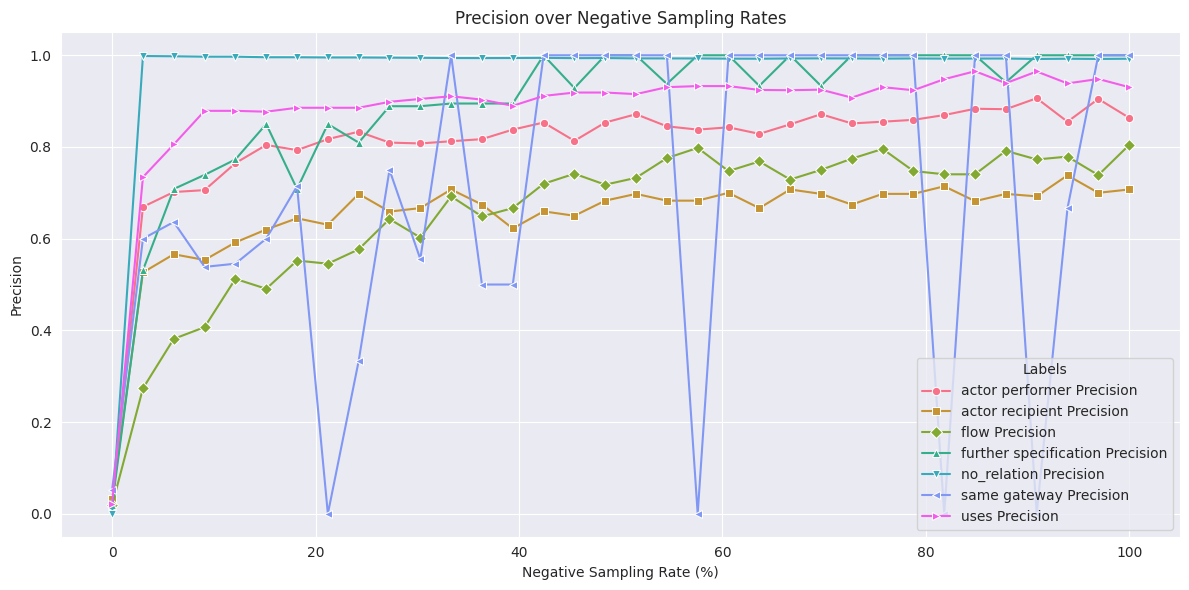

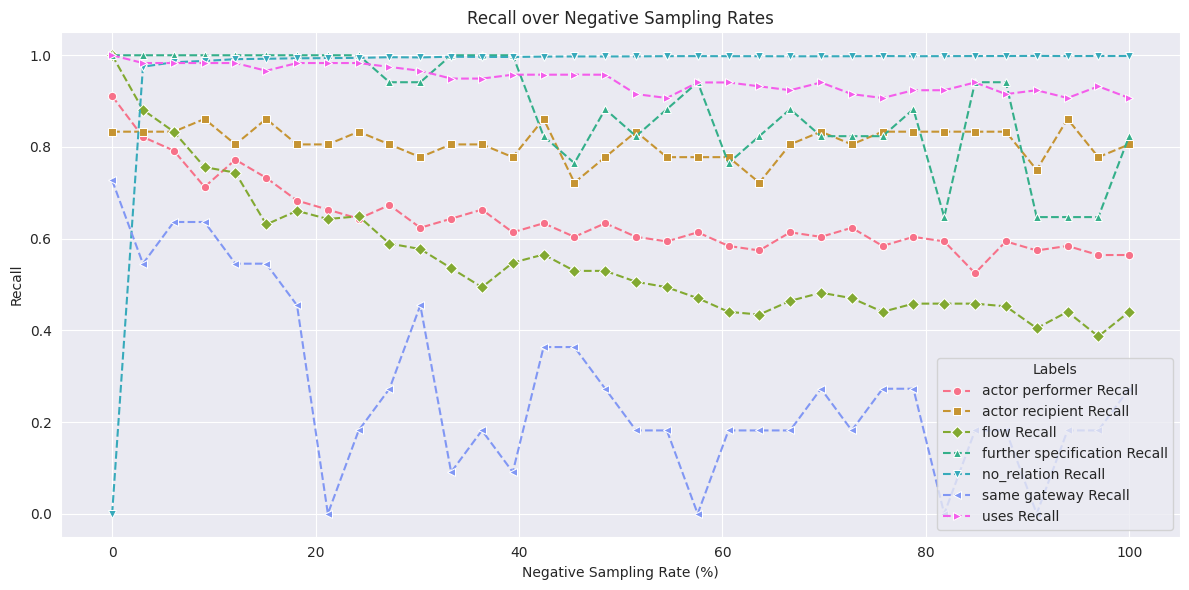

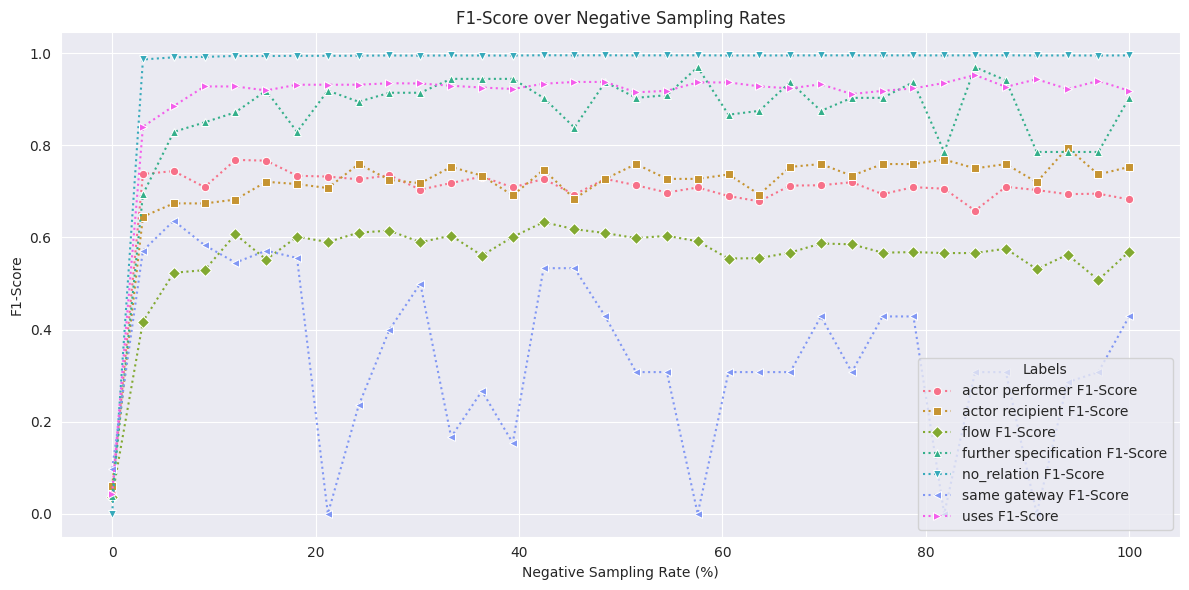

In [ ]:
# You only have to give a path where the plots will be saved to, the script dynamically makes a file name
saved_path = '/content/drive/MyDrive/THESIS/DATA/PET/catboost OUTPUTS/'
plot_separate_metrics(results, saved_path)

Here we plot metrics across all labels. Note that the previous cell has to be run.

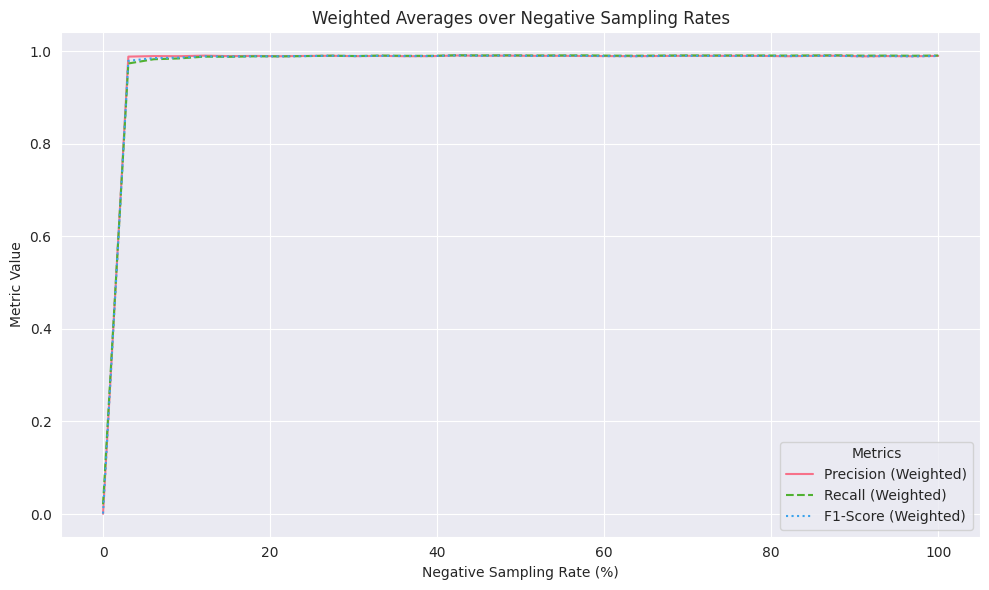

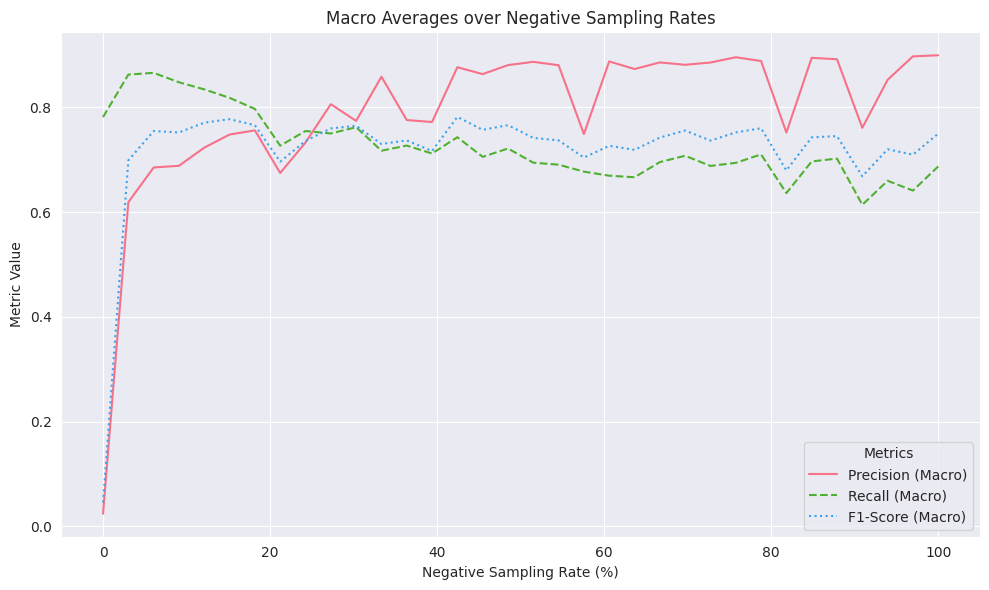

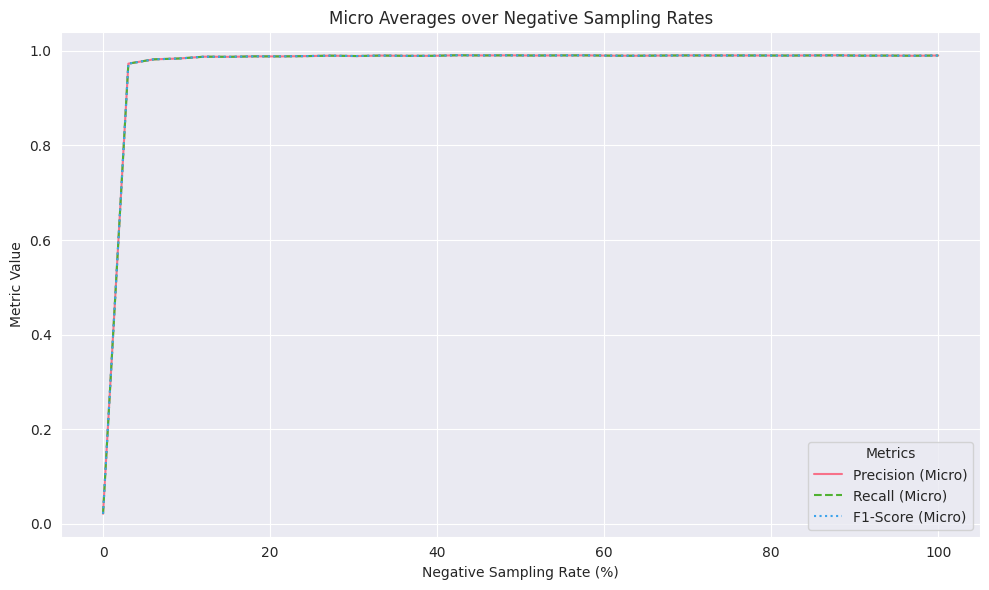

In [ ]:
plot_aggregated_metrics(results_aggregated, saved_path)

#4. SMOTE

From empirical testing we note that "flow" is performing quite poorly, even though this relationship is critical in modelling BPMN models. To adress this issue we will use another technique on top of Negative Sampling in order to improve the metric for this relationship type. The oversampling technique SMOTE will artificially create new instances of "flow" and add it to the training data.

##4.1. Pre-Processing

A preprocessing step is essential because it transforms mixed data types into a consistent numerical format suitable for machine learning models. By encoding ordinal and categorical features into numeric values that retain their inherent ordering or categorical nature, the models can accurately compute distances and relationships between data points, which is crucial for techniques like SMOTE to handle imbalanced data and for classifiers to learn meaningful patterns from the features. We use the sklearn OrdinalEncoder for this purpose: to translate the current data type into one that SMOTE can understand.

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for generating word embeddings by aggregating global word-word co-occurrence statistics from a corpus. It produces vector representations of words where the geometric relationships between the vectors capture semantic relationships between the words.

Essentially we need GloVe to translate the tokens into a format that is interpretable to SMOTE. The function below will load the pre-trained glove model.

In [ ]:
def load_glove_model(glove_file_path):
    """Load the GloVe model as a dictionary."""
    embedding_dict = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = list(map(float, values[1:]))
            embedding_dict[word] = vector
    return embedding_dict

# Path to your GloVe file
glove_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/GloVe pre-trained/glove.6B.300d.txt'

# Load the GloVe model
glove_model = load_glove_model(glove_path)

In [ ]:
# @title Pre-Processing functions
def embed_token(token):
    # Return the GloVe vector for a token, or a zero vector if the token is not found.
    vector_size = len(next(iter(glove_model.values())))  # Determine the vector size from the first element
    return glove_model.get(token, np.zeros(vector_size))

# Function to create a DataFrame with embedded vectors for all tokens in a column
def embed_token_column(df, column_name):
    # vector_size = len(next(iter(glove_model.values())))  # Determine the vector size from the first element
    return pd.DataFrame([embed_token(token) for token in df[column_name]],
                        columns=[f'{column_name}_emb_{i}' for i in range(vector_size)],
                        index=df.index)

# Function to preprocess data
def preprocess_data(df):
    # Specify the column groups for encoding
    ordinal_columns = ['source_token_ID', 'source_sentence_ID', 'target_token_ID', 'target_sentence_ID']
    categorical_columns = [
        'source_type', 'source_pos_tag', 'source_prev_tag', 'source_next_tag',
        'target_type', 'target_pos_tag', 'target_prev_tag', 'target_next_tag',
        'dependency_tags', 'document_name'
    ]
    numeric_columns = ['token_distance', 'sentence_distance']

    # Encode non-ordinal categorical columns with OneHotEncoder
    one_hot_df = pd.DataFrame()
    if categorical_columns:
        encoder = OneHotEncoder(sparse=False, drop='first')
        encoded = encoder.fit_transform(df[categorical_columns])
        one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(), index=df['relation_type'])

    one_hot_df = one_hot_df.reset_index(drop=True)

    # Encode ordinal columns with OrdinalEncoder
    ordinal_df = pd.DataFrame()
    if ordinal_columns:
        encoder = OrdinalEncoder()
        encoded = encoder.fit_transform(df[ordinal_columns])
        ordinal_df = pd.DataFrame(encoded, columns=ordinal_columns, index=df.index)

    # Use numeric columns as they are
    numeric_df = df[numeric_columns].copy() if numeric_columns else pd.DataFrame()

    # Embed token columns
    source_token_df = embed_token_column(df, 'source_token')
    target_token_df = embed_token_column(df, 'target_token')

    #Ensure adding the target
    le = LabelEncoder()
    target_label_df = pd.DataFrame(le.fit_transform(df['relation_type']), columns=['relation_type'], index=df['relation_type'])
    target_label_df = target_label_df.reset_index(drop=True)

    # Save the LabelEncoder for later use
    global label_encoder
    label_encoder = le

    assert numeric_df.index.is_unique, "Duplicate indices in numeric_df"
    assert ordinal_df.index.is_unique, "Duplicate indices in ordinal_df"
    assert one_hot_df.index.is_unique, "Duplicate indices in one_hot_df"
    assert source_token_df.index.is_unique, "Duplicate indices in source_token_df"
    assert target_token_df.index.is_unique, "Duplicate indices in target_token_df"
    assert target_label_df.index.is_unique, "Duplicate indices in target_label_df"


    # Concatenate all DataFrames
    df_final = pd.concat([numeric_df, ordinal_df, one_hot_df, source_token_df, target_token_df, target_label_df], axis=1)

    return df_final

#5. RandomOverSampler

We also experiment with a RandomOverSampler. RandomOverSampler is a technique to address class imbalance in datasets by increasing the number of instances in a (minority) class. It does this by randomly replicating samples from the class until the desired class balance is achieved. The downside is that it tends to overfit to the training data. Since no pre-processing is needed, there is no specific data handling code. See section 2 for the specific crossvalidation code on RandomOverSample.

#6. Results

This section outlines the results for the Catboost models trained with different data. The data has been modified in each subsection using various techniques.

##6.1. Baseline Crossvalidation

Here you can run and consult the result of the baseline Catboost model using crossvalidation without the use of special performance enhancing techniques.

In [ ]:
folds = 5
test_size = 0.2
best_model = crossvalidation(total, SEED, test_size, folds, use_class_weights=True)

# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model.cbm"
best_model.save_model(model_path, format="cbm")

<ipython-input-8-fa9969d7c269>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

source_type                         16.32          
sentence_distance                   15.0           
target_type                         13.61          
token_distance                      8.66           
target_token_ID                     6.51           
target_sentence_ID                  5.9            
source_token_ID                     4.94           
target_pos_tag                      4.24           
source_sentence_ID                  3.81           
source_next_tag                     3.67           
source_pos_tag                      3.34           
source_token                        3.02           
target_prev_tag                     2.87           
target_next_tag                     2.53           
source_pre

##6.2. Negative Sampling

Using Negative Sampling on the majority class to modify the data and train a new Catboost Model. From section 3 we concluded that a sampling rate of 15 is appropiate and thus set the sampling_rate to 15.

###6.2.1 Negative Sampling Data Creation

In [ ]:
# Run this for init data negative sampling
folds = 5
sampling_rate = 15
test_size = 0.2
train_neg, test_neg = train_test_split(total, test_size=0.2, stratify=total['relation_type'], random_state=SEED)
# Total needs to be the total dataset. We then make the separation again.
df_true_relation = train_neg[train_neg['relation_type'] != "no_relation"]
df_no_relation = train_neg[train_neg['relation_type'] == "no_relation"]
new_data = negative_sampling(df_true_relation, df_no_relation, sampling_rate, SEED)
data_negative_sampling = copy.deepcopy(new_data) #for clarity

###6.2.2 Negative Sampling Crossvalidation

In [ ]:
best_model_neg_sample = crossvalidation_neg(data_negative_sampling, test_neg, SEED, test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model_using_NEGSAMPLE.cbm"
best_model_neg_sample.save_model(model_path, format="cbm")

<ipython-input-9-ca8ffca765d9>:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

sentence_distance                   17.71          
source_type                         15.55          
target_type                         11.83          
token_distance                      8.18           
target_token_ID                     5.12           
source_next_tag                     5.1            
target_pos_tag                      4.82           
source_token_ID                     4.24           
target_sentence_ID                  4.01           
source_pos_tag                      3.98           
source_sentence_ID                  3.41           
target_token                        3.31           
target_prev_tag                     3.03           
document_name                       2.65           
source_tok

##6.3 SMOTE

###6.3.1 SMOTE with Negative Sampling

We perform a crossvalidation on the catboost model that was trained using the negative sampling data created in section 6.2 and enriched it with synthetic examples of 'flow'. For implementation of the crossvalidation see section 2.3.



First we create new negative sampling data. The total data has to be pre-processed first and then split.

In [ ]:
# Run this for init data negative sampling
folds = 5
sampling_rate = 25
test_size = 0.2

# We first Preprocess the data to prepare it for SMOTE
input_data_smote = preprocess_data(total)

# Then we look for the encoded SMOTE label for 'no_relation', convert it to an integer using .item()
SMOTE_norel_label = label_encoder.transform(["no_relation"]).item()

# ...
train_neg_smote, test_neg_smote = train_test_split(input_data_smote, test_size=0.2, random_state=SEED)

# We then make the separation again.
df_true_relation = train_neg_smote[train_neg_smote['relation_type'] != SMOTE_norel_label]
df_no_relation = train_neg_smote[train_neg_smote['relation_type'] == SMOTE_norel_label]
new_data = negative_sampling(df_true_relation, df_no_relation, sampling_rate, SEED)
data_negative_sampling_SMOTE = copy.deepcopy(new_data) #for clarity

if not data_negative_sampling_SMOTE.empty:
  print("Data Loaded")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data Loaded


In [ ]:
best_model_SMOTE_neg_sample = crossvalidation_SMOTE(data_negative_sampling_SMOTE, test_neg_smote, SEED, test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model_using_SMOTE_NEGSAMPLE.cbm"
best_model_SMOTE_neg_sample.save_model(model_path, format="cbm")

<ipython-input-10-1205813b8751>:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

sentence_distance                   19.96          
token_distance                      6.72           
source_type_B-Activity              6.02           
target_type_B-Actor                 4.95           
target_sentence_ID                  2.54           
source_sentence_ID                  2.05           
target_type_B-Activity              2.02           
target_token_ID                     1.98           
target_type_B-XOR Gateway           1.56           
target_prev_tag_O                   1.43           
source_token_ID                     1.43           
target_type_B-Activity Data         1.3            
source_token_emb_278                1.17           
target_pos_tag_IN                   1.02           
source_pos

###6.3.2. SMOTE on baseline data

Crossvalidation was done using the baseline data that is enriched using SMOTE for the 'flow' relation only.

In [ ]:
best_model_SMOTE = crossvalidation_SMOTE(input_data_smote, "ignore", SEED, test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model_using_SMOTE.cbm"
best_model_SMOTE.save_model(model_path, format="cbm")

<ipython-input-10-1205813b8751>:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

sentence_distance                   18.9           
source_type_B-Activity              6.36           
token_distance                      4.9            
target_type_B-Actor                 4.67           
target_type_B-Activity              2.31           
target_sentence_ID                  2.3            
source_token_ID                     2.21           
target_token_ID                     1.89           
source_sentence_ID                  1.6            
source_pos_tag_IN                   1.34           
target_type_B-Activity Data         1.24           
target_pos_tag_IN                   1.18           
target_type_B-XOR Gateway           1.15           
target_token_emb_276                0.84           
source_nex

##6.4. Random Over Sampling (ROS)

###6.4.1 ROS with Negative Sampling

We perform a crossvalidation on the catboost model that was trained using the negative sampling data created in section 6.2 and enriched it with random samples of 'flow'. For implementation of the crossvalidation and the parameters see section 2.4.

In [ ]:
best_model_RANDOMOVERSAMPLE_neg_sample = crossvalidation_RANDOMOVERSAMPLE(data_negative_sampling, SEED, test_neg, test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model_using_RANDOMOVERSAMPLE_neg_sample.cbm"
best_model_RANDOMOVERSAMPLE_neg_sample.save_model(model_path, format="cbm")

<ipython-input-11-09bcef8f98c5>:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

sentence_distance                   17.1           
target_type                         13.73          
source_type                         12.76          
token_distance                      6.2            
target_pos_tag                      5.18           
target_token_ID                     5.15           
source_pos_tag                      4.63           
target_sentence_ID                  4.29           
source_token                        4.16           
target_next_tag                     4.0            
source_next_tag                     3.99           
source_token_ID                     3.95           
source_sentence_ID                  3.59           
target_token                        3.29           
target_pre

###6.4.2. ROS on baseline data

Crossvalidation was done using the baseline data that is enriched using ROS for the 'flow' relation only.

In [ ]:
best_model_RANDOMOVERSAMPLE = crossvalidation_RANDOMOVERSAMPLE(total, SEED, "ignore", test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TRAINED_CATBOOST_MODEL/best_catboost_model_using_RANDOMOVERSAMPLE.cbm"
best_model_RANDOMOVERSAMPLE.save_model(model_path, format="cbm")

<ipython-input-11-09bcef8f98c5>:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features_indices = [i for i, typ in enumerate(data_features.dtypes) if typ == 'object' or pd.api.types.is_categorical_dtype(data_features.iloc[:, i])]



---------------------------------------

Training fold 1...

---------------------------------------

Training succesfully finished!

---------------------------------------


Getting feature importances...

Feature                             Score          

sentence_distance                   15.49          
target_type                         12.97          
source_type                         12.7           
token_distance                      7.01           
target_token_ID                     6.47           
target_sentence_ID                  6.25           
source_token_ID                     5.31           
source_token                        4.97           
target_pos_tag                      4.62           
source_pos_tag                      4.28           
source_next_tag                     3.97           
source_sentence_ID                  3.72           
target_prev_tag                     2.82           
source_prev_tag                     2.57           
document_n

#6.5. CONCLUSION

Among the various sampling strategies tested, ***ROS on baseline data*** resulted in the highest Macro F1 score of ***0.7921***, indicating the best overall performance across all classes. This approach also performed best for the 'flow' class specifically, with an F1 score of ***0.6200***.

For the 'flow' class, the ROS on baseline data strategy yielded the highest F1 score of 0.6200, followed closely by the baseline approach with an F1 score of 0.6022.

The baseline data and negative sampling only approaches provided balanced performance, with high Macro F1 scores (0.7795 and 0.7429 respectively) and moderately good performance for the 'flow' class (0.6022 and 0.6039 respectively).



#7. Model for Pipeline Integration

In this section we select the model from the best fold from the crossvalidation using the optimal method obtained from section 6 to be used in the pipeline.

##7.1 Data Inputs

This subsection will manipulate the data to keep a separate test document.

###7.1.1 Training Model excluding 6DOCS

For the purposes of pipeline testing we exclude 6 documents from model training.

In [ ]:
# Define the paths to the PET and LESCHNEIDER data, you get this data by running "Feature Generation for CatBoost".
path1 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_PET1.1.csv' #feature of neighbours before and after
path2 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_LESCHNEIDER.csv'

df_PET = pd.read_csv(path1)
df_LESCHNEIDER = pd.read_csv(path2)


total = pd.concat([df_PET, df_LESCHNEIDER], ignore_index=True)

# Select the document name you want to remove

doc_excl_list = ['doc-3.1', 'doc-9.3', 'doc-8.2', 'doc-10.7', 'doc-20.5 - edit pictures', 'doc-10.12']

test_doc = total[total['document_name'].isin(doc_excl_list)]
rel_pipeline_data = total[~total['document_name'].isin(doc_excl_list)]
print(test_doc[test_doc['document_name']== 'doc-8.2'])

if not test_doc.empty and not rel_pipeline_data.empty:
  print('data loaded')

###7.1.2 Training Model on FULL DATA

For the purpose of training a demo pipeline, we trained the model on the full data.

In [ ]:
# Define the paths to the PET and LESCHNEIDER data, you get this data by running "Feature Generation for CatBoost".
path1 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_PET1.1.csv' #feature of neighbours before and after
path2 = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/RE_TRAINING_DATA/total_relation_entity_pairs_DEPENDENCY_CONTEXT_md_LESCHNEIDER.csv'

df_PET = pd.read_csv(path1)
df_LESCHNEIDER = pd.read_csv(path2)


total = pd.concat([df_PET, df_LESCHNEIDER], ignore_index=True)

##7.2 Model Training and Saving

Using this data we now crossvalidate and chose the best model. This model is then saved for use in our pipeline. You have to do this twice, once for the testing pipeline, and once for the demo pipeline.

In [ ]:
folds = 5
test_size = 0.2
best_model_ROS = crossvalidation_RANDOMOVERSAMPLE(total, SEED, "ignore", test_size, folds, use_class_weights=True)
# Save the best model to a file
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/RE MODELS/best_catboost_ROS_PIPELINE_FULL_DATA.cbm"
best_model_ROS.save_model(model_path, format="cbm")